# Welcome to the PEZ Dispenser!
### The Juypter Notebook for "Hard Prompts Made Easy: Gradient-Based Discrete Optimization for Prompt Tuning and Discovery"
### [Paper Link](https://arxiv.org/abs/2302.03668)
### [GitHub Link](https://github.com/YuxinWenRick/hard-prompts-made-easy)

The name PEZ (hard ***P***rompts made ***E***a**Z**y) was inspired from the [PEZ candy dispenser](https://us.pez.com/collections/dispensers).<!--  and can be obtained from the title: hard ***P***rompts made ***E***a**Z**y   -->

### Goal: Generate new images from Stable Diffusion given an original image.

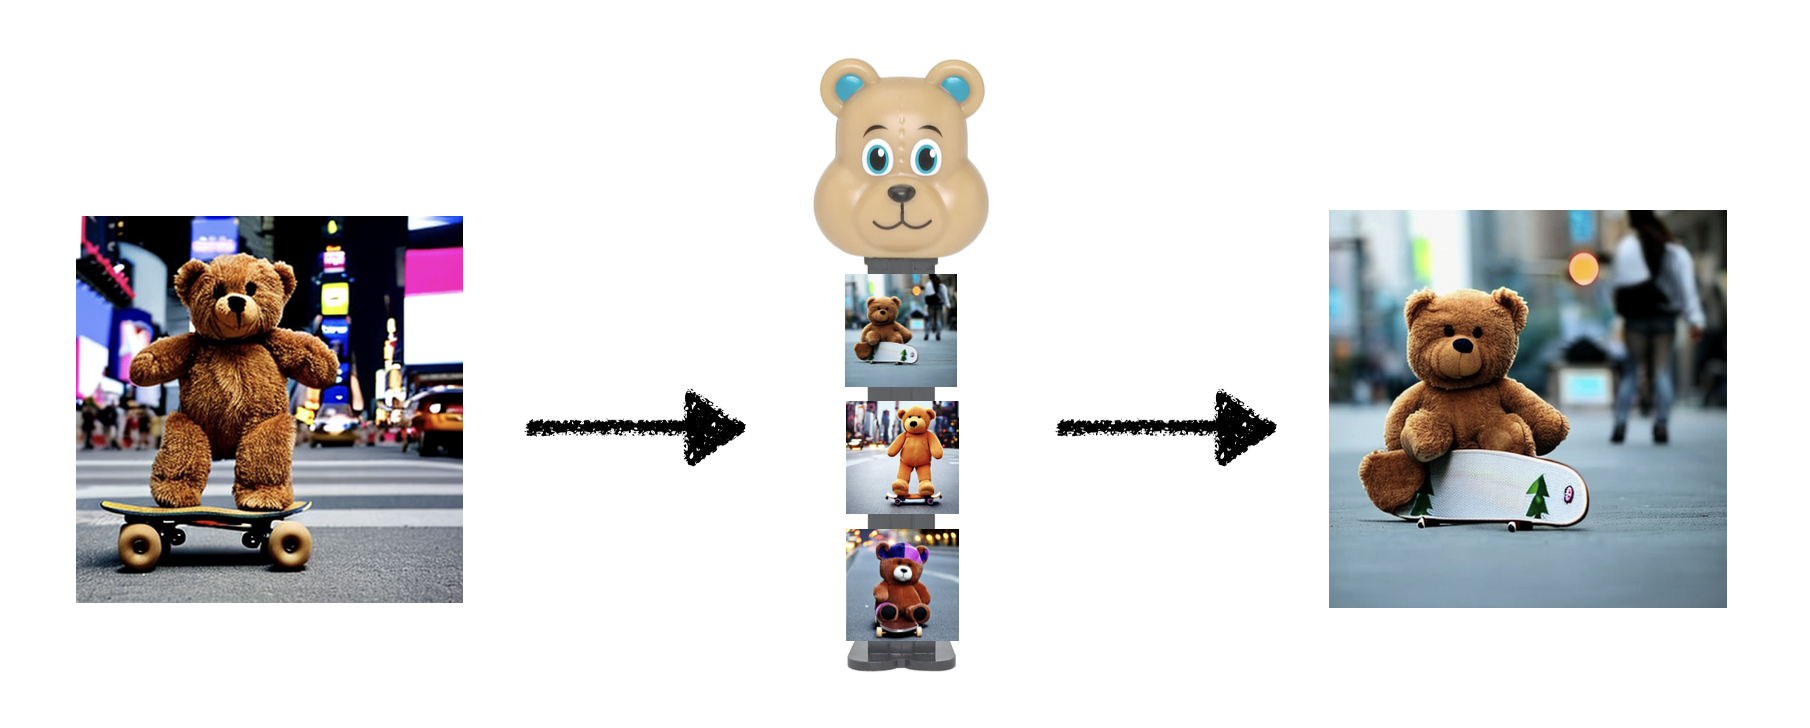

# Process Overview

From a given image, we first optimize a prompt using the PEZ algorithm and CLIP encoders. Then, we take the optimized prompts and feed them into Stable Diffusion to generate new images.

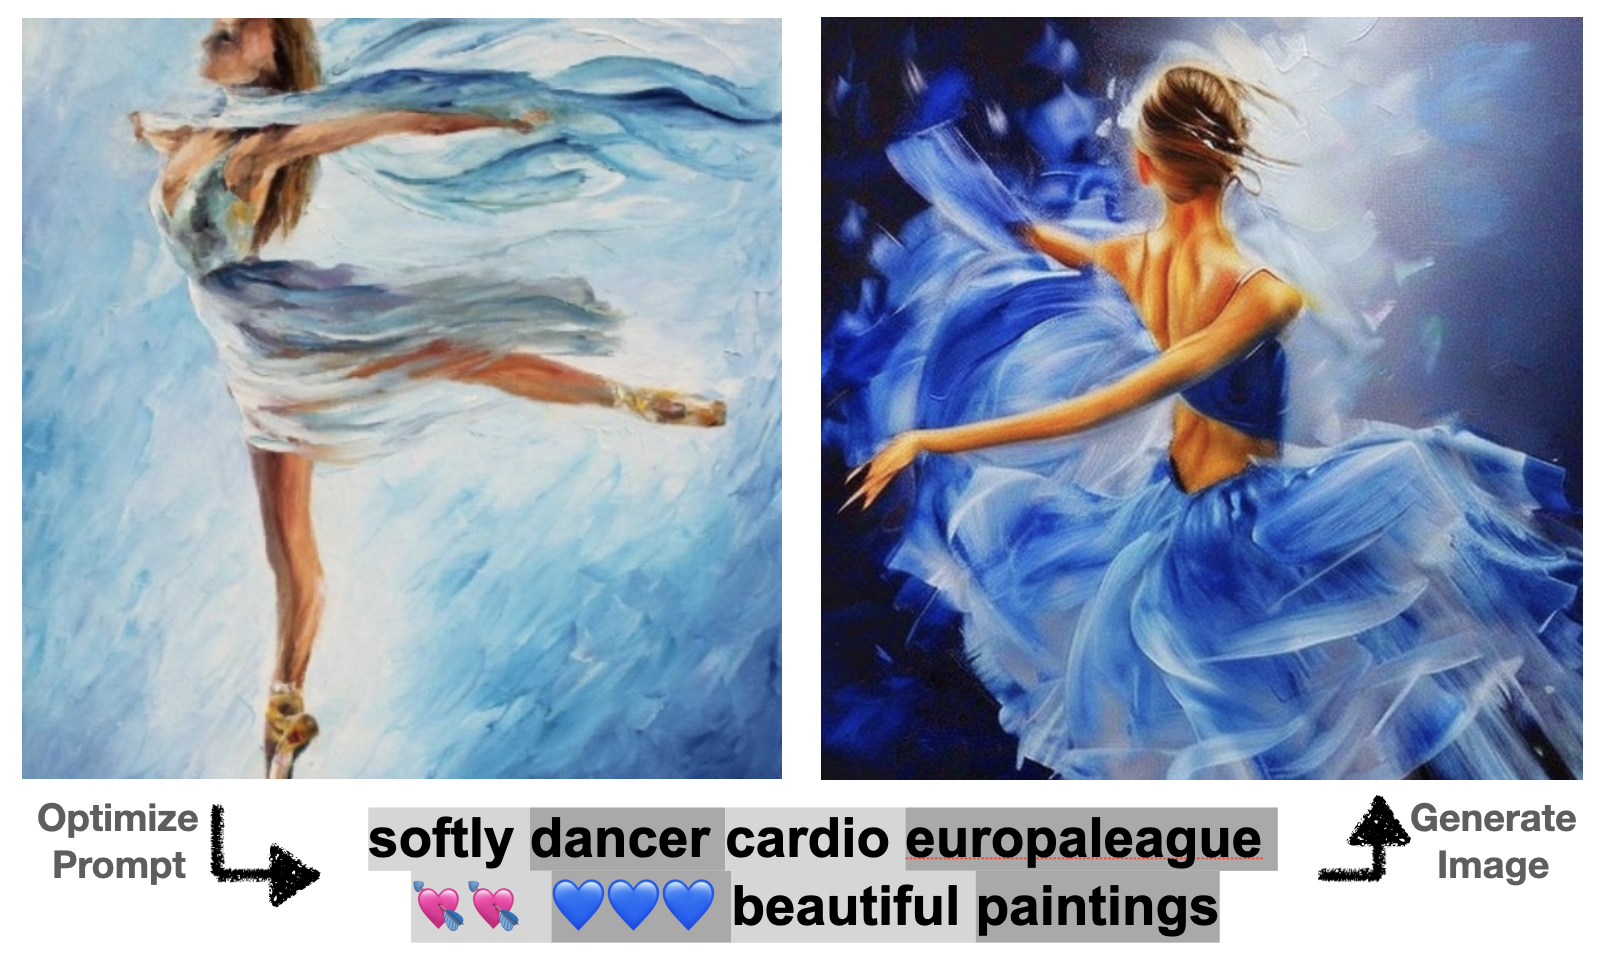

# Install Requirements

In [ ]:
#pip install transformers sentence-transformers ftfy mediapy diffusers napm

In [ ]:
#import sys
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install transformers==4.23.1 sentence-transformers==2.2.2 ftfy==6.1.1 mediapy==1.1.2 diffusers==0.11.1
#     !git clone https://github.com/YuxinWenRick/hard-prompts-made-easy
#     %cd hard-prompts-made-easy
import napm
url = 'https://github.com/YuxinWenRick/hard-prompts-made-easy'
napm.pseudoinstall_git_repo(url, add_install_dir_to_path=True, package_name='pez')
#help(napm.pseudoinstall_git_repo)

In [ ]:
import torch
import open_clip
import mediapy as media
#from optim_utils import *
from pez.optim_utils import *

import argparse

# Load Arguments

In [ ]:
#args = argparse.Namespace()
#args.__dict__.update(read_json("sample_config.json"))
args = argparse.Namespace(**{
    "prompt_len": 16,
    "iter": 3000,
    "lr": 0.1,
    "weight_decay": 0.1,
    "prompt_bs": 1,
    "loss_weight": 1.0,
    "print_step": 100,
    "batch_size": 1,
    "clip_model": "ViT-H-14",
    "clip_pretrain": "laion2b_s32b_b79k"
})

# Load Clip Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, clip_preprocess = open_clip.create_model_and_transforms(args.clip_model, pretrained=args.clip_pretrain, 
                                                                device=device)

tokenizer = open_clip.tokenizer._tokenizer
token_embedding = model.token_embedding
preprocess = clip_preprocess

# Load Diffusion Model

In [ ]:
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision="fp16",
    )
pipe = pipe.to(device)

image_length = 512

# Load Image

In [ ]:
# load image
urls = [
        "https://a.1stdibscdn.com/alexander-averin-paintings-pony-riding-on-the-beach-post-impressionist-style-oil-painting-for-sale-picture-6/a_7443/a_28523631526593507117/Promenade_detalle_5_master.JPG?disable=upscale&auto=webp&quality=60&width=1318",
       ]

orig_images = list(filter(None,[download_image(url) for url in urls]))
media.show_images(orig_images)

# Optimize Prompt

In [ ]:
learned_prompt = optimize_prompt(model, preprocess, args, device, target_images=orig_images)

# Generate with Stable Diffusion Model

In [ ]:
# you can customize the learned prompt here
prompt = learned_prompt

In [ ]:
num_images = 4
guidance_scale = 9
num_inference_steps = 25

images = pipe(
    prompt,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    ).images

print(f"prompt: {prompt}")
media.show_images(images)